In [1]:
import numpy as np
np.random.seed(20)  # Зафиксировать seed для numpy
import tensorflow as tf
tf.random.set_seed(20)  # Зафиксировать seed для TensorFlow 2.x
from keras import backend as K
K.clear_session()

2023-12-19 13:05:53.412199: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-19 13:05:53.413662: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-19 13:05:53.437997: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-19 13:05:53.438023: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-19 13:05:53.438040: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

In [3]:
import numpy as np

In [4]:
import pandas as pd
if IN_COLAB:
    file = google.colab.files.upload('Загрузите файл данных с солнечной электростанции')
    data = pd.read_csv(file)
else:
    data = pd.read_csv('~/Study/SolarPower/AutoLSTM/GermanSolarFarm/data/selected_pv_01.csv', delimiter=',')
data = data.drop('Unnamed: 0', axis=1)

unused_features = [
    'SolarRadiationGlobalAt0',
    'SolarRadiationDirectAt0',
    'power_normed'
]
for feature in unused_features:
    data = data.drop(feature, axis=1)
radiation = data.pop('SolarRadiationDiffuseAt0')

print('Dataset size: ', data.shape)
print(data.columns)


Dataset size:  (6217, 15)
Index(['hour_of_day', 'month_of_year', 'season_of_year', 'sunposition_thetaZ',
       'sunposition_solarAzimuth', 'sunposition_extraTerr',
       'sunposition_solarHeight', 'LowerWindSpeed', 'LowerWindDirection',
       'TotalCloudCoverAt0', 'DewpointTemperatureAt0', 'TemperatureAt0',
       'RelativeHumidityAt0', 'SurfacePressureAt0', 'SnowDepthAt0'],
      dtype='object')


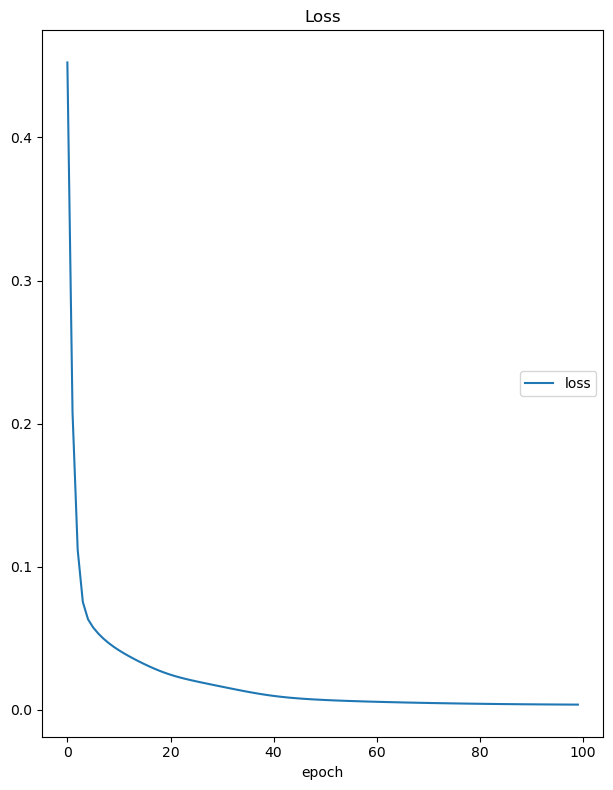

Loss
	loss             	 (min:    0.004, max:    0.452, cur:    0.004)
63/63 [==============================] - 0s 2ms/step - loss: 0.0035


In [5]:
from keras import models, optimizers, callbacks
from keras.layers import Input, Dense
from keras.layers import InputLayer

from livelossplot import PlotLossesKeras


input_dim = data.shape[1]
ae_out_dim = input_dim / 2

autoencoder = models.Sequential()

autoencoder.add(InputLayer(input_shape=(input_dim,)))  # input_dim - размер входных данных
autoencoder.add(Dense(ae_out_dim)) # узкое место - половина размерности выходных данных
autoencoder.add(Dense(input_dim))  # input_dim - размер выходных данных

autoencoder.compile(optimizer='adam', loss='mse')

features = np.array(data)

early_stop = callbacks.EarlyStopping(monitor="val_loss", patience=1, min_delta=0.001)
autoencoder.fit(features, features, epochs=100, batch_size=100, shuffle=False, verbose=1, callbacks=[PlotLossesKeras()])

1/1 [==============================] - 0s 41ms/step
(6217, 15)
(1, 15)


<BarContainer object of 15 artists>

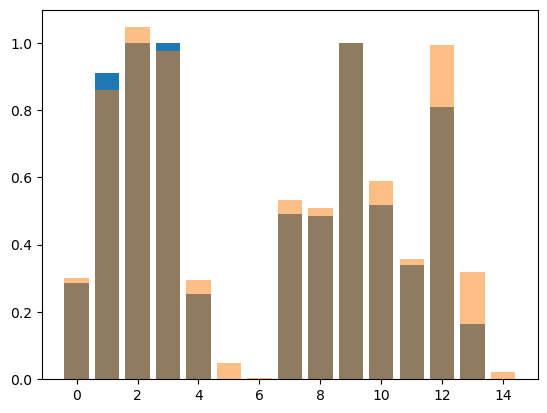

In [6]:
import matplotlib.pyplot as plt

autoencoder.evaluate(features, features)
test_idx = 10 # random :)
prediction = autoencoder.predict(np.reshape(features[test_idx], [1, input_dim]))
print(np.shape(features))
print(np.shape(prediction))

plt.bar(range(len(features[test_idx])), features[test_idx])
plt.bar(range(len(prediction[0])), prediction[0], alpha=0.5,)

In [7]:
autoencoder.pop()
autoencoder.compile()
autoencoder.summary()
autoencoder.predict(features)[0]


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7)                 112       
                                                                 
Total params: 112 (448.00 Byte)
Trainable params: 112 (448.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
195/195 [==============================] - 0s 463us/step


array([-0.59854925, -0.9360491 , -0.9203463 ,  0.8144923 ,  1.0406921 ,
       -1.0053333 ,  0.42906976], dtype=float32)

In [8]:
features = autoencoder.predict(features)

195/195 [==============================] - 0s 759us/step


In [9]:
features.shape

(6217, 7)

In [10]:
def prepareData(features, radiation, history_size, forecast_lenth):
    x = []
    y = []
    for i in range(history_size, len(features)):
        x.append(features[i - history_size : i])
        y.append(radiation[i])
    return np.array(x), np.array(y)

In [11]:
from sklearn.model_selection import train_test_split

history_interval = 12 # ~1 day
forecast_lenth = history_interval

x, y = prepareData(features, radiation, history_interval, forecast_lenth)
test_idx = int(0.8 * len(x))

x_test = x[test_idx:]
y_test = y[test_idx:]

x_train, x_val, y_train, y_val = train_test_split(x[:test_idx], y[:test_idx], test_size=0.1, random_state=20, shuffle=False)

In [12]:
import tensorflow as tf
from keras import layers
from keras import models
from keras import metrics

model = models.Sequential()
model.add(layers.LSTM(256, activation='tanh', input_shape=(history_interval, int(ae_out_dim)), return_sequences=True))
model.add(layers.LSTM(128, activation='tanh', return_sequences=True))
model.add(layers.LSTM(64, activation='tanh', return_sequences=True))
model.add(layers.LSTM(32, activation='tanh', return_sequences=True))
model.add(layers.LSTM(24, activation='relu'))
model.add(layers.Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=[metrics.RootMeanSquaredError()])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 256)           270336    
                                                                 
 lstm_1 (LSTM)               (None, 12, 128)           197120    
                                                                 
 lstm_2 (LSTM)               (None, 12, 64)            49408     
                                                                 
 lstm_3 (LSTM)               (None, 12, 32)            12416     
                                                                 
 lstm_4 (LSTM)               (None, 24)                5472      
                                                                 
 dense_2 (Dense)             (None, 1)                 25        
                                                                 
Total params: 534777 (2.04 MB)
Trainable params: 53477

In [13]:
np.shape(x_train)

(4467, 12, 7)

In [14]:
np.shape(y_train)

(4467,)

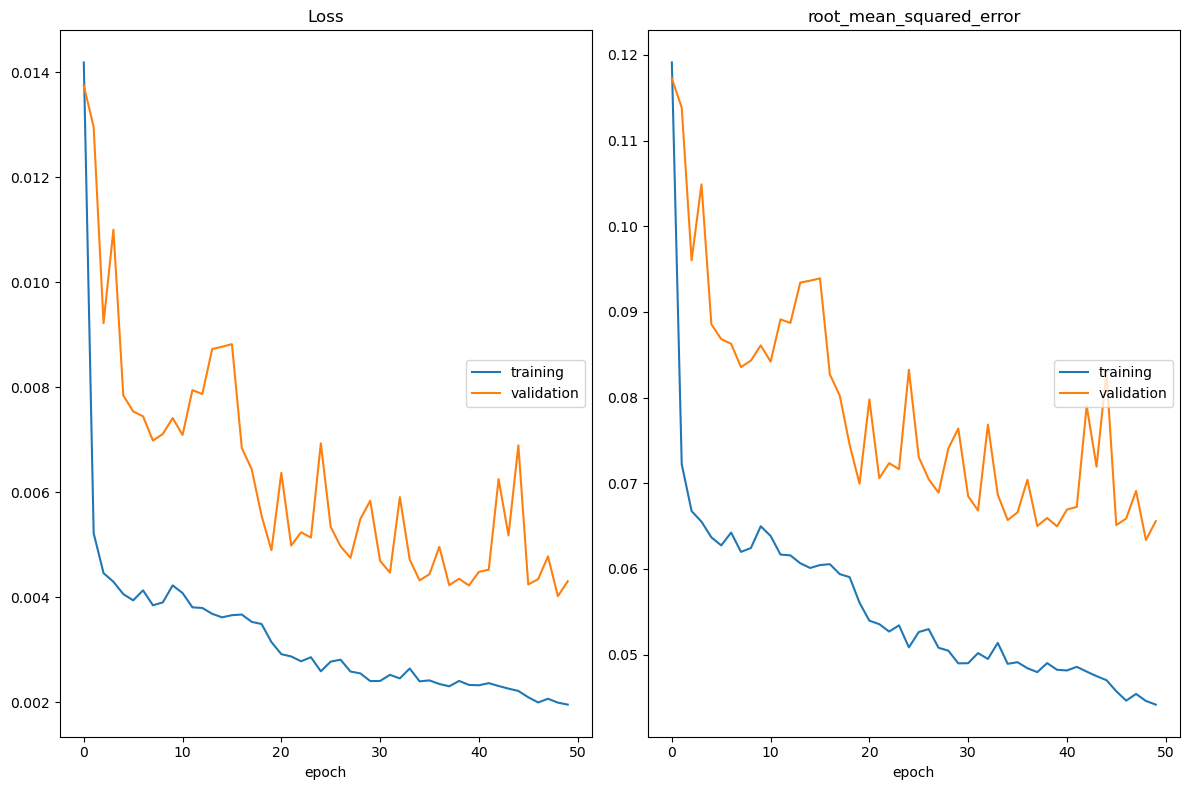

Loss
	training         	 (min:    0.002, max:    0.014, cur:    0.002)
	validation       	 (min:    0.004, max:    0.014, cur:    0.004)
root_mean_squared_error
	training         	 (min:    0.044, max:    0.119, cur:    0.044)
	validation       	 (min:    0.063, max:    0.117, cur:    0.066)
140/140 [==============================] - 7s 50ms/step - loss: 0.0020 - root_mean_squared_error: 0.0442 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0656 - lr: 5.0000e-04


In [15]:
from livelossplot import PlotLossesKeras

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-8)

model.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val), callbacks=[PlotLossesKeras(), reduce_lr])

In [16]:
results = model.evaluate(x_test, y_test, batch_size=128)
np.shape(y_test)

10/10 [==============================] - 0s 42ms/step - loss: 0.0023 - root_mean_squared_error: 0.0483


(1241,)

In [ ]:

from ipywidgets import interact, IntSlider

prediction = model.predict(x_test)
max_idx = len(prediction)
hours_per_dot = 3 # const
hours_per_plot = 48
dots_per_plot = int(hours_per_plot / hours_per_dot)


def plot_graph(index):
    x_axis = [x * hours_per_dot for x in range(0, dots_per_plot)]
    plt.plot(x_axis, prediction[index : index + dots_per_plot], label='prediction', marker='o')
    plt.plot(x_axis, y_test[index : index + dots_per_plot], label='actual', marker='o')
    plt.ylabel('Target')
    plt.ylim(0, 1)
    plt.xlabel('Hours')
    plt.legend()
    plt.show()

interact(plot_graph, index=IntSlider(min=0, max=max_idx - dots_per_plot , step=1, value=0))